In [1]:
import cv2
import torch
import urllib.request
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import copy
import gc
import tifffile 

In [2]:
def get_depthMap(image_data, is_path=True):

    model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
    #model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
    #model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
    midas = torch.hub.load("intel-isl/MiDaS", model_type)

    USE_GPU = True
    device = torch.device('mps') if (USE_GPU and torch.backends.mps.is_available()) else torch.device('cpu')
    #print('using device:', device)
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    
    if is_path:
        original_img = Image.open(image_data)
    else:
        original_img = image_data
    img = np.array(original_img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            # mode="bicubic",
            # align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    output_image = Image.fromarray(output)
    output_image = output_image.convert('RGB')

    gc.collect()
    
    return output

In [ ]:
image = Image.open("data_set/0.png")
image_depth_map = get_depthMap("data_set/0.png")
image_mask = cv2.imread("data_set/0_mask.png", cv2.IMREAD_GRAYSCALE)
closed_mask = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, np.ones((100,100),np.uint8))

In [ ]:
figure, axis = plt.subplots(2, 2)
axis[0, 0].imshow(image)
axis[0, 1].imshow(image_depth_map)
axis[1, 0].imshow(image_mask)
axis[1, 1].imshow(closed_mask)

In [ ]:
corolle_patch = np.zeros_like(image_depth_map)
corolle_patch[closed_mask == 255] = image_depth_map[closed_mask == 255]
plt.imshow(corolle_patch)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image_mask)
indices = np.array(np.where(image_mask == 255))
pixel = indices[:,-1]
pt = patches.Circle((index[1], index[0]), radius = 5, edgecolor = 'r', fill = False)



In [ ]:
background = Image.open("backgrounds/1.jpeg")
background_map = get_depthMap("backgrounds/1.jpeg")

In [ ]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(background)
axis[1].imshow(background_map)

In [ ]:
result = Image.open("backgrounds/1.jpeg").convert("RGBA")

mask_aux = np.repeat(image_mask[:,:, None], 4, axis=2)
corolle_mask = np.where(mask_aux == 255, 1, mask_aux)
corolle = Image.fromarray(image * corolle_mask)
result.paste(corolle, (pos_x, pos_y), Image.fromarray(image_mask))

result_mask = Image.fromarray(np.repeat(np.zeros_like(background_map)[:,:, None], 3, axis=2).astype(np.uint8))
result_mask.paste(Image.fromarray(closed_mask), (pos_x, pos_y))


result_depth_pasted = Image.fromarray(np.repeat(background_map[:,:, None], 4, axis=2).astype(np.uint8))
#corolle_depth_aux = Image.fromarray(np.repeat(image_depth_map[:,:, None], 4, axis=2).astype(np.uint8))
result_depth_pasted.paste(Image.fromarray(image_depth_map), (pos_x, pos_y), Image.fromarray(image_mask))

figure, axis = plt.subplots(2, 2, figsize=(10, 10))
axis[0, 0].imshow(result)
axis[0, 1].imshow(result_mask)
axis[1, 0].imshow(result_depth_processed)
axis[1, 1].imshow(np.array(result_depth_pasted)[:,:,0])



In [3]:


"""
From a folder full of background images it returns all images and its ndarray depths as two arrays
"""
def get_background_depths(backgrounds_folder):
    print("Getting background depth maps...")
    backgrounds = []
    background_depths = []
    for background in os.listdir(backgrounds_folder):
        background_path = os.path.join(backgrounds_folder, background)
        backgrounds.append(Image.open(background_path))
        background_depths.append(get_depthMap(background_path))
    return backgrounds, background_depths


"""
From a folder full of corolle images and masks it returns all images, depths, masks and closed_masks (without
holes)
"""
def get_corolles_information(corolles_folder):
    hole_filler = np.ones((100,100),np.uint8)
        
    corolles = []
    corolles_depths = []
    corolles_masks = []
    corolles_closed_masks = []
    for corolle in os.listdir(corolles_folder):
        corolle_path = os.path.join(corolles_folder, corolle)
        if not "mask" in corolle_path:
            corolles.append(Image.open(corolle_path))
            corolles_depths.append(get_depthMap(corolle_path))
            corolle_mask_path = corolle_path.replace(".png", "_mask.png")
            corolle_mask = cv2.imread(corolle_mask_path, cv2.IMREAD_GRAYSCALE)
            corolles_masks.append(corolle_mask)
            corolle_closed_mask = cv2.morphologyEx(corolle_mask, cv2.MORPH_CLOSE, hole_filler)
            corolles_closed_masks.append(corolle_closed_mask)
            
    return corolles, corolles_depths, corolles_masks, corolles_closed_masks

def resize(image, size):
    return cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)

def create_examples(backgrounds_folder, corolles_folder):
    color_margin = 0.3
    
    print("Getting background depth maps...")
    backgrounds, background_depths = get_background_depths(backgrounds_folder)
    
    print("Getting corolles information...")
    corolles, corolles_depths, corolles_masks, corolles_closed_masks = get_corolles_information(corolles_folder)
     
    
    for b_index, background in enumerate(backgrounds):
        background_depth = background_depths[b_index]
        background_height, background_width = background_depth.shape
        
        
        for c_index, corolle in enumerate(corolles):
            corolle = corolle.resize((background_width,background_width), Image.Resampling.LANCZOS)
            corolle_depth = resize(corolles_depths[c_index], (background_width, background_width))
            corolle_depth_image = Image.fromarray(corolle_depth)
            
            corolle_mask = resize(corolles_masks[c_index], (background_width, background_width))
            mask_aux = np.repeat(corolle_mask[:,:, None], 4, axis=2)
            mask_aux = np.where(mask_aux == 255, 1, mask_aux)
            
            corolle = Image.fromarray(corolle * mask_aux)
            corolle_mask_image = Image.fromarray(corolle_mask)
            
            corolle_closed_mask = resize(corolles_closed_masks[c_index], (background_width,background_width))
            corolle_union_coord = np.array(np.where(corolle_closed_mask == 255))[:, -1]
            
            union_color = corolle_depth[corolle_union_coord[0], corolle_union_coord[1]]
            possible_unions = np.array(np.where(abs(background_depth - union_color) < color_margin)).T
            filtered_coords = possible_unions[(possible_unions[:, 1] >= background_width/3) &
                                      (possible_unions[:, 1] <= background_width * 2/3) &
                                      (possible_unions[:, 0] >= background_height/2)]
            
            coords = np.random.choice(filtered_coords.shape[0], 5, replace=False)            
            for i in range(5):
                print("Placing tree at: {}".format(filtered_coords[coords[i]]))
                background_union_coord = filtered_coords[coords[i]]
                position = background_union_coord - corolle_union_coord
                                
                result = copy.deepcopy(background)
                result.paste(corolle, (position[1], position[0]), corolle_mask_image)
                
                result_mask = Image.fromarray(np.repeat(np.zeros_like(background_depth)[:,:, None], 3, axis=2).astype(np.uint8))
                result_mask.paste(Image.fromarray(corolle_closed_mask),  (position[1], position[0]))
                result_depth = get_depthMap(result, False)
        
                result_depth_pasted = Image.fromarray(np.repeat(background_depth[:,:, None], 3, axis=2).astype(np.uint8))
                result_depth_pasted.paste(corolle_depth_image, (position[1], position[0]), corolle_mask_image)

                file_name = "background_{}_image_{}_coord_{}".format(b_index, c_index, i)
                
                print("Creating file {}".format(file_name))
                np.save('results/images/A1{}.npy'.format(file_name), np.array(result))
                np.save('results/masks/A1{}.npy'.format(file_name), np.array(result_mask)[:, :, 0])
                np.save('results/depths/A1{}.npy'.format(file_name), result_depth.astype(np.uint8))
                np.save('results/depths_pasted/A1{}.npy'.format(file_name), np.array(result_depth_pasted)[:, :, 0])
                gc.collect()
        del backgrounds[0]
        del background_depths[0]


In [ ]:
# Debugging:
print("Getting background depth maps...")
backgrounds, background_depths = get_background_depths("backgrounds_ex")
    
print("Getting corolles information...")
corolles, corolles_depths, corolles_masks, corolles_closed_masks, corolles_union_coords = get_corolles_information("data_set_ex")

In [4]:
create_examples("backgrounds_ex", "data_set_ex")

Getting background depth maps...
Getting background depth maps...


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS

Getting corolles information...


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Placing tree at: [1906 1666]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_0_coord_0
Placing tree at: [1900 1794]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_0_coord_1
Placing tree at: [1883 2348]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_0_coord_2
Placing tree at: [1921 1314]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_0_coord_3
Placing tree at: [1906 1578]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_0_coord_4
Placing tree at: [1791 1808]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_1_coord_0
Placing tree at: [1791 1772]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_1_coord_1
Placing tree at: [1793 1721]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_1_coord_2
Placing tree at: [1794 1569]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_1_coord_3
Placing tree at: [1772 2457]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_1_coord_4
Placing tree at: [1803 1737]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_2_coord_0
Placing tree at: [1791 1940]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_2_coord_1
Placing tree at: [1800 1914]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_2_coord_2
Placing tree at: [1803 1397]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_2_coord_3
Placing tree at: [1782 2132]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_0_image_2_coord_4
Placing tree at: [5525 1469]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_0_coord_0
Placing tree at: [5540 1726]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_0_coord_1
Placing tree at: [5527 2010]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_0_coord_2
Placing tree at: [5528 1380]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_0_coord_3
Placing tree at: [5512 1379]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_0_coord_4
Placing tree at: [5257 1485]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_1_coord_0
Placing tree at: [5268 1832]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_1_coord_1
Placing tree at: [5249 1757]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_1_coord_2
Placing tree at: [5269 1606]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_1_coord_3
Placing tree at: [5270 1835]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_1_coord_4
Placing tree at: [5275 2068]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_2_coord_0
Placing tree at: [5280 2641]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_2_coord_1
Placing tree at: [5276 2475]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_2_coord_2
Placing tree at: [5272 1817]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_2_coord_3
Placing tree at: [5282 1756]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_1_image_2_coord_4
Placing tree at: [4373 1376]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_0_coord_0
Placing tree at: [4367 1740]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_0_coord_1
Placing tree at: [4382 1561]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_0_coord_2
Placing tree at: [4399 1824]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_0_coord_3
Placing tree at: [4381 1556]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_0_coord_4
Placing tree at: [4075 1363]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_1_coord_0
Placing tree at: [4068 2008]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_1_coord_1
Placing tree at: [4067 2266]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_1_coord_2
Placing tree at: [4063 1530]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_1_coord_3
Placing tree at: [4058 2207]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_1_coord_4
Placing tree at: [4107 1637]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_2_coord_0
Placing tree at: [4111 2165]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_2_coord_1
Placing tree at: [4116 2375]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_2_coord_2
Placing tree at: [4107 2431]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_2_coord_3
Placing tree at: [4115 2133]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_2_image_2_coord_4
Placing tree at: [3345 2593]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_0_coord_0
Placing tree at: [3325 2009]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_0_coord_1
Placing tree at: [3333 2057]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_0_coord_2
Placing tree at: [3348 2931]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_0_coord_3
Placing tree at: [3333 2478]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_0_coord_4
Placing tree at: [3164 3546]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_1_coord_0
Placing tree at: [3132 3026]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_1_coord_1
Placing tree at: [3128 2382]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_1_coord_2
Placing tree at: [3110 2015]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_1_coord_3
Placing tree at: [3126 2797]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_1_coord_4
Placing tree at: [3147 2613]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_2_coord_0
Placing tree at: [3142 2341]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_2_coord_1
Placing tree at: [3159 2653]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_2_coord_2
Placing tree at: [3139 2406]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_2_coord_3
Placing tree at: [3135 2382]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_3_image_2_coord_4
Placing tree at: [2456 1822]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_0_coord_0
Placing tree at: [2483 3149]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_0_coord_1
Placing tree at: [2444 1687]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_0_coord_2
Placing tree at: [2461 2100]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_0_coord_3
Placing tree at: [2486 3050]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_0_coord_4
Placing tree at: [2364 2486]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_1_coord_0
Placing tree at: [2369 3238]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_1_coord_1
Placing tree at: [2373 2801]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_1_coord_2
Placing tree at: [2334 1902]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_1_coord_3
Placing tree at: [2378 3232]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_1_coord_4
Placing tree at: [2385 2938]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_2_coord_0
Placing tree at: [2384 3074]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_2_coord_1
Placing tree at: [2386 3155]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_2_coord_2
Placing tree at: [2347 2050]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_2_coord_3
Placing tree at: [2373 2436]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_4_image_2_coord_4
Placing tree at: [2330 1557]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_0_coord_0
Placing tree at: [2333 1460]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_0_coord_1
Placing tree at: [2326 1659]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_0_coord_2
Placing tree at: [2334 2840]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_0_coord_3
Placing tree at: [2324 1909]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_0_coord_4
Placing tree at: [2200 2069]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_1_coord_0
Placing tree at: [2194 2776]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_1_coord_1
Placing tree at: [2195 2444]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_1_coord_2
Placing tree at: [2174 2660]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_1_coord_3
Placing tree at: [2196 1778]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_1_coord_4
Placing tree at: [2216 2070]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_2_coord_0
Placing tree at: [2202 2342]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_2_coord_1
Placing tree at: [2217 1568]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_2_coord_2
Placing tree at: [2215 2797]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_2_coord_3
Placing tree at: [2216 1602]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_5_image_2_coord_4
Placing tree at: [3139 2795]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_0_coord_0
Placing tree at: [3147 1989]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_0_coord_1
Placing tree at: [3111 3063]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_0_coord_2
Placing tree at: [3125 1925]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_0_coord_3
Placing tree at: [3132 2769]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_0_coord_4
Placing tree at: [2892 2470]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_1_coord_0
Placing tree at: [2904 1833]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_1_coord_1
Placing tree at: [2882 2312]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_1_coord_2
Placing tree at: [2876 3252]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_1_coord_3
Placing tree at: [2899 2591]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_1_coord_4
Placing tree at: [2918 2444]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_2_coord_0
Placing tree at: [2913 2535]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_2_coord_1
Placing tree at: [2904 2775]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_2_coord_2
Placing tree at: [2897 3372]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_2_coord_3
Placing tree at: [2902 3132]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_6_image_2_coord_4
Placing tree at: [2489 2410]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_0_coord_0
Placing tree at: [2482 1691]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_0_coord_1
Placing tree at: [2489 2111]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_0_coord_2
Placing tree at: [2479 1580]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_0_coord_3
Placing tree at: [2475 2371]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_0_coord_4
Placing tree at: [2340 1917]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_1_coord_0
Placing tree at: [2323 2580]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_1_coord_1
Placing tree at: [2342 2301]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_1_coord_2
Placing tree at: [2330 1766]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_1_coord_3
Placing tree at: [2343 2299]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_1_coord_4
Placing tree at: [2353 2171]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_2_coord_0
Placing tree at: [2347 1776]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_2_coord_1
Placing tree at: [2357 2231]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_2_coord_2
Placing tree at: [2341 1726]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_2_coord_3
Placing tree at: [2340 1650]


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Creating file background_7_image_2_coord_4


In [32]:
def check_result(name):
    figure, axis = plt.subplots(2, 2)
    axis[0, 0].imshow(Image.fromarray(np.load("results/images/{}".format(name))))
    axis[0, 1].imshow(Image.fromarray(np.load("results/masks/{}".format(name))))
    axis[1, 0].imshow(Image.fromarray(np.load("results/depths/{}".format(name))))
    axis[1, 1].imshow(Image.fromarray(np.load("results/depths_pasted/{}".format(name))))

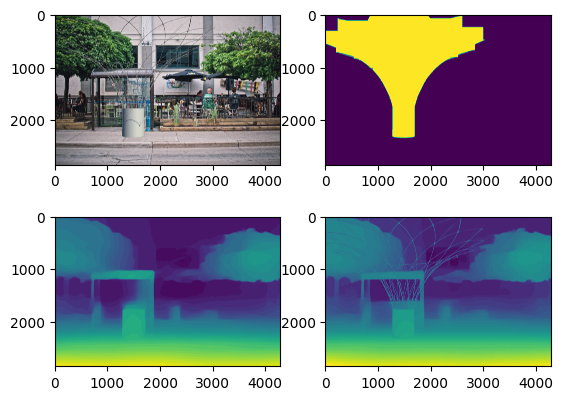

In [33]:
background = 5
image = 0
coord = 0
check_result("A1background_{}_image_{}_coord_{}.npy".format(background, image, coord))

In [13]:
def translate_files(directory):
    for i, filename in enumerate(os.listdir(directory)):
        array = np.load("{}/{}".format(directory, filename))
        print(array.shape)
        tifffile.imsave("{}_tif/{}.tif".format(directory, i), array)

In [14]:
translate_files("results/depths_pasted")

(2848, 4288)
(3264, 4928)
(3456, 5184)
(2592, 3888)


/tmp/ipykernel_13707/1927239771.py:5: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("{}_tif/{}.tif".format(directory, i), array)


(5184, 3456)
(2848, 4288)
(2848, 4288)
(3130, 2075)
(3264, 4928)
(3456, 5184)
(1500, 2000)
(6000, 4000)
(3351, 5322)
(2848, 4288)
(6000, 4000)
(6000, 4000)
(3264, 4928)
(3456, 5184)
(5923, 3949)
(4032, 3024)
(5923, 3949)
(1500, 2000)
(2592, 3888)
(5923, 3949)
(3042, 4078)
(3456, 5184)
(2848, 4288)
(2667, 4000)
(4032, 3024)
(4032, 3024)
(2667, 4000)
(1500, 1000)
(5923, 3949)
(5563, 3691)
(2592, 3888)
(3042, 4078)
(6000, 4000)
(2592, 3888)
(3042, 4078)
(3351, 5322)
(3659, 5489)
(2200, 2069)
(3456, 5184)
(1200, 1880)
(2848, 4288)
(1200, 1880)
(1500, 2000)
(400, 600)
(3456, 5184)
(3264, 4928)
(2848, 4288)
(6000, 4000)
(1500, 2000)
(2667, 4000)
(3042, 4078)
(3042, 4078)
(6000, 4000)
(5923, 3949)
(2848, 4288)
(3351, 5322)
(3042, 4078)
(5923, 3949)
(2592, 3888)
(2667, 4000)
(3042, 4078)
(3456, 5184)
(3264, 4928)
(2667, 4000)
(6000, 4000)
(5184, 3456)
(1080, 1920)
(2667, 4000)
(2667, 4000)
(2848, 4288)
(2667, 4000)
(3456, 5184)
(1080, 1920)
(3456, 5184)
(3419, 2642)
(7358, 4908)
(4032, 3024)
(

40 0


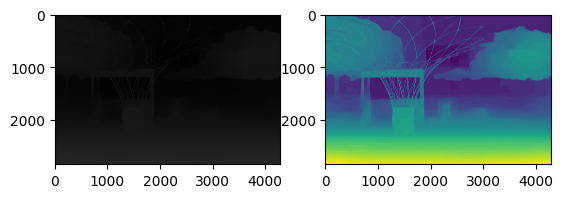

In [37]:
img = cv2.imread("results/depths_pasted_tif/0.tif")
data = np.array(img)
print(np.max(data), np.min(data))
figure, axis = plt.subplots(1, 2)
axis[0].imshow(Image.fromarray(data))
axis[1].imshow(Image.fromarray(data[:, :, 0]))